In [1]:
"""
01_data_profiling.ipynb
======================
Pierwsza analiza danych dla Retail Omnichannel Optimization
Autor: Paweł Żołądkiewicz
Data: 12 sierpnia 2025

Cel: Poznanie datasetu, identyfikacja problemów jakościowych,
     przygotowanie do budowy modelu gwiazdy.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("🚀 Rozpoczynamy analizę Online Retail II dataset")
print("=" * 50)
print(f"Python version: {pd.__version__}")
print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M')}")


🚀 Rozpoczynamy analizę Online Retail II dataset
Python version: 2.3.1
Current time: 2025-08-13 19:00


In [2]:
# =======================================
# SPRAWDZENIE ZAWARTOŚCI PLIKU EXCEL
# =======================================

import pandas as pd

print("ANALIZA PLIKU EXCEL")
print("=" * 35)

file_path = '../data/raw/online_retail_II.xlsx'

# Sprawdź jakie zakładki są w pliku
xl_file = pd.ExcelFile(file_path)
sheet_names = xl_file.sheet_names

print(f"Znalezione zakładki: {sheet_names}")
print(f"Liczba zakładek: {len(sheet_names)}")

# Sprawdź rozmiar każdej zakładki
for sheet in sheet_names:
    temp_df = pd.read_excel(file_path, sheet_name=sheet)
    print(f"* {sheet}: {len(temp_df):,} rekordów")
    print(f"* Zakres dat: {temp_df['InvoiceDate'].min()} -> {temp_df['InvoiceDate'].max()}")


ANALIZA PLIKU EXCEL
Znalezione zakładki: ['Year 2009-2010', 'Year 2010-2011']
Liczba zakładek: 2
* Year 2009-2010: 525,461 rekordów
* Zakres dat: 2009-12-01 07:45:00 -> 2010-12-09 20:01:00
* Year 2010-2011: 541,910 rekordów
* Zakres dat: 2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [3]:
# ===========================================================
# WCZYTANIE DATASETU ONLINE RETAIL II - Z ANALIZĄ DUPLIKATÓW  
# ===========================================================

print("Wczytywanie Online Retail II dataset...")

# Ścieżka względna z notebooks folder
file_path = '../data/raw/online_retail_II.xlsx'

try:
    # Sprawdź dostępne arkusze
    xl_file = pd.ExcelFile(file_path)
    sheet_names = xl_file.sheet_names
    print(f"Dostępne arkusze: {sheet_names}")

    # Wczytaj oba arkusze
    sheets_data = {}
    for sheet in sheet_names:
        sheets_data[sheet] = pd.read_excel(file_path, sheet_name=sheet)
        print(f"\nArkusz '{sheet}':")
        print(f"   - Rekordów: {len(sheets_data[sheet]):,}")
        print(f"   - Kolumny: {list(sheets_data[sheet].columns)}")
        print(f"   - Zakres dat: {sheets_data[sheet]['InvoiceDate'].min()} → {sheets_data[sheet]['InvoiceDate'].max()}")

    # Analiza nakładających się danych (duplikaty)
    print(f"\n" + "=" * 50)
    print("ANALIZA NAKŁADAJĄCYCH SIĘ DANYCH (DUPLIKATY)")
    print("=" * 50)

    if len(sheet_names) == 2:
        sheet1_name, sheet2_name = sheet_names[0], sheet_names[1]
        df1, df2 = sheets_data[sheet1_name], sheets_data[sheet2_name]

        # Klucz do weryfikacji pod kątem duplikatów
        def create_transaction_key(df):
            return (df['Invoice'].astype(str) + "_" + 
                    df['StockCode'].astype(str) + "_" + 
                    df['Quantity'].astype(str) + "_" +
                    pd.to_datetime(df['InvoiceDate']).dt.strftime('%Y%m%d_%H%M') + "_" +
                    df['Price'].astype(str))

        df1['full_transaction_key'] = create_transaction_key(df1)
        df2['full_transaction_key'] = create_transaction_key(df2)

        # Sprtawdź duplikaty WEWNĄTRZ każdego arkusza

        df1_internal_dupes = df1[df1.duplicated(subset=['full_transaction_key'], keep=False)]
        df2_internal_dupes = df2[df2.duplicated(subset=['full_transaction_key'], keep=False)]

        print(f"DUPLIKATY WEWNĘTRZNE:")
        print(f"Arkusz 1 wewnętrzne duplikaty: {len(df1_internal_dupes):,}")
        print(f"Arkusz 2 wewnętrzne duplikaty: {len(df2_internal_dupes):,}")

        # Sprawdź nakładanie MIĘDZY arkuszami
        df1_unique_keys = set(df1['full_transaction_key'].unique())
        df2_unique_keys = set(df2['full_transaction_key'].unique())
        common_keys = df1_unique_keys.intersection(df2_unique_keys)

        print(f"\nDUPLIKATY POMIĘDZY ARKUSZAMI:")
        print(f"Arkusz 1 unikalne klucze: {len(df1_unique_keys):,}")
        print(f"Arkusz 2 unikalne klucze: {len(df2_unique_keys):,}")
        print(f"Wspólne klucze między arkuszami: {len(common_keys):,}")

        # Zlicz ile rekordów odpowiada wspólnym kluczom
        df1_common_records = df1[df1['full_transaction_key'].isin(common_keys)]
        df2_common_records = df2[df2['full_transaction_key'].isin(common_keys)]

        print(f"Liczba rekordów z wspólnymi kluczami w arkuszu 1: {len(df1_common_records):,}")
        print(f"Liczba rekordów z wspólnymi kluczami w arkuszu 2: {len(df2_common_records):,}")

        # POPRAWNA KONSOLIDACJA
        print(f"\nPOPRAWNA STRATEGIA KONSOLIDACJI:")

        # Krok 1: Usuń duplikaty wewnętrzne w każdym arkuszu
        df1_clean = df1.drop_duplicates(subset=['full_transaction_key'], keep='first')
        df2_clean = df2.drop_duplicates(subset=['full_transaction_key'], keep='first')

        print(f"Po wewnętrznej deduplikacji:")
        print(f"Arkusz 1: {len(df1):,} → {len(df1_clean):,} (usunięto {len(df1) - len(df1_clean):,})")
        print(f"Arkusz 2: {len(df2):,} → {len(df2_clean):,} (usunięto {len(df2) - len(df2_clean):,})")
                                        
        # Krok 2: Połącz i usuń duplikaty między arkuszami
        df_combined = pd.concat([df1_clean, df2_clean], ignore_index=True)
        df_final = df_combined.drop_duplicates(subset=['full_transaction_key'], keep='first')

        print(f"\nPo konsolidacji między arkuszami:")
        print(f"Przed merge: {len(df_combined):,}")
        print(f"Po merge: {len(df_final):,}")
        print(f"Liczba usuniętych duplikatów między arkuszami: {len(df_combined) - len(df_final):,}")

        # PODSUMOWANIE LOGICZNE 
        total_internal_removed = (len(df1) - len(df1_clean)) + (len(df2) - len(df2_clean))
        between_sheets_removed = len(df_combined) - len(df_final)
        total_removed = total_internal_removed + between_sheets_removed

        print(f"\nPODSUMOWANIE KOŃCOWE:")
        print(f"Usunięto duplikatów wewnętrznych: {total_internal_removed:,}")
        print(f"Usunięto duplikatów między arkuszami: {between_sheets_removed:,}")
        print(f"ŁĄCZNIE usunięto duplikatów: {total_removed:,}")
        print(f"Wspólne klucze między arkuszami: {len(common_keys):,}")

        # Sprawdź czy logika jest spójna
        if between_sheets_removed == len(common_keys):
            print("LOGIKA POPRAWNA: Usunięte duplikaty = wspólne klucze")
        else:
            print("SPRAWDŹ: Logika wymaga dalszej analizy")

        # Finalny dataset
        df = df_final.drop('full_transaction_key', axis=1)
        
   
    # Konwersja datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    print(f"\nFINALNY DATASET:")
    print(f"Rekordów: {len(df):,}")
    print(f"Kolumny: {list(df.columns)}")
    print(f"Rozmiar: {df.memory_usage(deep=True).sum() / 1014**2:.1f} MB")
    print(f"Okres: {df['InvoiceDate'].min()} → {df['InvoiceDate'].max()}")
    print("GOTOWE DO ANALIZY!")
    
except FileNotFoundError:
    print("BŁĄD: Brak pliku online_retail_II.xlsx")
    print("Pobierz z: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II")
except Exception as e:
    print(f"BŁĄD: {str(e)}")


Wczytywanie Online Retail II dataset...
Dostępne arkusze: ['Year 2009-2010', 'Year 2010-2011']

Arkusz 'Year 2009-2010':
   - Rekordów: 525,461
   - Kolumny: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
   - Zakres dat: 2009-12-01 07:45:00 → 2010-12-09 20:01:00

Arkusz 'Year 2010-2011':
   - Rekordów: 541,910
   - Kolumny: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
   - Zakres dat: 2010-12-01 08:26:00 → 2011-12-09 12:50:00

ANALIZA NAKŁADAJĄCYCH SIĘ DANYCH (DUPLIKATY)
DUPLIKATY WEWNĘTRZNE:
Arkusz 1 wewnętrzne duplikaty: 13,283
Arkusz 2 wewnętrzne duplikaty: 10,151

DUPLIKATY POMIĘDZY ARKUSZAMI:
Arkusz 1 unikalne klucze: 518,596
Arkusz 2 unikalne klucze: 536,640
Wspólne klucze między arkuszami: 22,202
Liczba rekordów z wspólnymi kluczami w arkuszu 1: 22,523
Liczba rekordów z wspólnymi kluczami w arkuszu 2: 22,523

POPRAWNA STRATEGIA KONSOLIDACJI:
Po wewnętrznej deduplikacj

In [4]:
# =================================
# ANALIZA JAKOŚCI PO KONSOLIDACJI
# ==================================

print("KONTROLA JAKOŚCI PO KONSOLIDACJI")
print("=" * 35)

# Analiza rozkładu dat między arkuszami (jeśli to był podział czasowy)
print("ROZKŁAD CZASOWY:")
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
yearly_dist = df.groupby('Year').size()
print("Rozkład roczny:")
for year, count in yearly_dist.items():
    print(f"  {year}: {count:,} rekordów")

# Sprawdź, czy była logika podziału arkuszy
if len(sheet_names) == 2:
    # Przykłady możliwych krtyteriów podziału:
    print(f"\nMOŻLIWE KRYTERIA PODZIAŁU ARKUSZY:")

    # Podział czasowy?
    df1_years = set(sheets_data[sheet1_name]['InvoiceDate'].dt.year)
    df2_years = set(sheets_data[sheet2_name]['InvoiceDate'].dt.year)
    if df1_years != df2_years:
        print(f"* Podział czasowy: Arkusz 1 ({list(df1_years)}) vs Arkusz 2 ({list(df2_years)}")

    # Podział geograficzny?
    df1_countries = set(sheets_data[sheet1_name]['Country'].unique())
    df2_countries = set(sheets_data[sheet2_name]['Country'].unique())
    common_countries = df1_countries.intersection(df2_countries)
    if len(common_countries) < min(len(df1_countries), len(df2_countries)):
        print(f"* Częściowy podział geograficzny: {len(common_countries)} wspólnych krajów")

    print(f"\nPO KONSOLIDACJI - METRYKI DATASET:")
    print(f"* Łączne unikalne faktury: {df['Invoice'].nunique():,}")
    print(f"* Łączni unikalni Klienci: {df['Customer ID'].nunique():,}")
    print(f"* Łączne unikalne produkty: {df['StockCode'].nunique():,}")
    print(f"* Jakość danych po konsolidacji - weryfikacja w kolejnych komórkach/krokach")


KONTROLA JAKOŚCI PO KONSOLIDACJI
ROZKŁAD CZASOWY:
Rozkład roczny:
  2009: 44,722 rekordów
  2010: 493,653 rekordów
  2011: 494,659 rekordów

MOŻLIWE KRYTERIA PODZIAŁU ARKUSZY:
* Podział czasowy: Arkusz 1 ([2009, 2010]) vs Arkusz 2 ([2010, 2011]
* Częściowy podział geograficzny: 35 wspólnych krajów

PO KONSOLIDACJI - METRYKI DATASET:
* Łączne unikalne faktury: 53,628
* Łączni unikalni Klienci: 5,942
* Łączne unikalne produkty: 5,305
* Jakość danych po konsolidacji - weryfikacja w kolejnych komórkach/krokach


In [5]:
# ==========================================
# ANALIZA STRUKTURY I BASIC STATS
# ==========================================

print("PODSTAWOWA ANALIZA STRUKTURY")
print("=" * 40)

# Info o typach danych
print("TYPY DANYCH I PAMIĘĆ:")
df.info()

print("\n" + "="*40)
print("STATYSTYKI NUMERYCZNE:")
display(df.describe())

print("\n" + "="*40) 
print("UNIKALNE WARTOŚCI PER KOLUMNA:")
for col in df.columns:
    unique_count = df[col].nunique()
    null_count = df[col].isnull().sum()
    null_pct = (null_count / len(df)) * 100
    print(f"• {col:<15}: {unique_count:>8,} unique | {null_count:>8,} nulls ({null_pct:>5.1f}%)")

# Sample data preview
print("\n" + "="*40)
print("PIERWSZE 5 REKORDÓW:")
display(df.head())


PODSTAWOWA ANALIZA STRUKTURY
TYPY DANYCH I PAMIĘĆ:
<class 'pandas.core.frame.DataFrame'>
Index: 1033034 entries, 0 to 1055235
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1033034 non-null  object        
 1   StockCode    1033034 non-null  object        
 2   Description  1028759 non-null  object        
 3   Quantity     1033034 non-null  int64         
 4   InvoiceDate  1033034 non-null  datetime64[ns]
 5   Price        1033034 non-null  float64       
 6   Customer ID  797883 non-null   float64       
 7   Country      1033034 non-null  object        
 8   Year         1033034 non-null  int32         
 9   Month        1033034 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(4)
memory usage: 78.8+ MB

STATYSTYKI NUMERYCZNE:


,Quantity,InvoiceDate,Price,Customer ID,Year,Month
count,1.033034e+06,1033034,1.033034e+06,797883.000000,1.033034e+06,1.033034e+06
mean,1.007661e+01,2011-01-03 14:29:57.887697920,4.613982e+00,15313.068776,2.010436e+03,7.393367e+00
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000,2.009000e+03,1.000000e+00
25%,1.000000e+00,2010-07-05 11:38:00,1.250000e+00,13964.000000,2.010000e+03,4.000000e+00
50%,3.000000e+00,2010-12-09 13:34:00,2.100000e+00,15228.000000,2.010000e+03,8.000000e+00
75%,1.000000e+01,2011-07-27 13:17:00,4.150000e+00,16788.000000,2.011000e+03,1.100000e+01
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000,2.011000e+03,1.200000e+01
std,1.751976e+02,NaN,1.223976e+02,1696.464558,5.765676e-01,3.500954e+00



UNIKALNE WARTOŚCI PER KOLUMNA:
• Invoice        :   53,628 unique |        0 nulls (  0.0%)
• StockCode      :    5,305 unique |        0 nulls (  0.0%)
• Description    :    5,698 unique |    4,275 nulls (  0.4%)
• Quantity       :    1,057 unique |        0 nulls (  0.0%)
• InvoiceDate    :   47,635 unique |        0 nulls (  0.0%)
• Price          :    2,807 unique |        0 nulls (  0.0%)
• Customer ID    :    5,942 unique |  235,151 nulls ( 22.8%)
• Country        :       43 unique |        0 nulls (  0.0%)
• Year           :        3 unique |        0 nulls (  0.0%)
• Month          :       12 unique |        0 nulls (  0.0%)

PIERWSZE 5 REKORDÓW:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12


ANALIZA BRAKUJĄCYCH DANYCH
PODSUMOWANIE MISSING DATA:


,Brakujące,Procent
Customer ID,235151,22.763142
Description,4275,0.413830


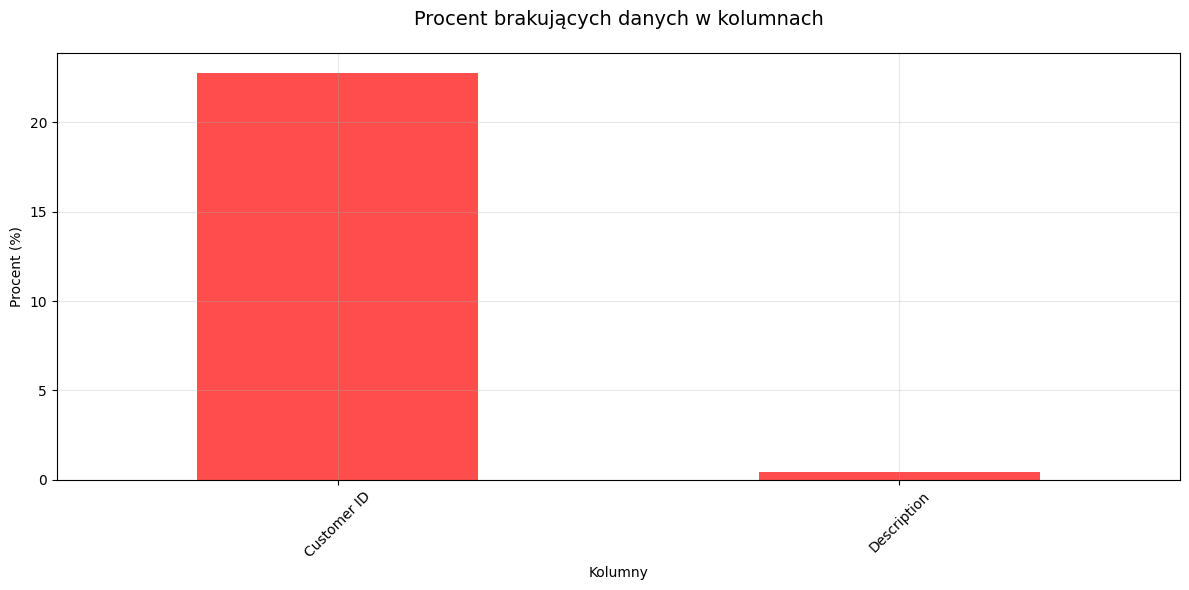


 WPŁYW BIZNESOWY:
* Guest purchases (brak Customer ID): 235,151 (22.8%)
* Impact: Ograniczona analiza customer lifetime value
* Rekomendacja: Osobna analiza guest vs registered customers


In [6]:
# ============================================
# ANALIZA BRAKUJĄCYCH DANYCH I WIZUALIZACJA
# ============================================

print("ANALIZA BRAKUJĄCYCH DANYCH")
print("=" * 35)

# Missing data summary
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Brakujące': missing_data,
    'Procent': missing_percent
}).sort_values('Procent', ascending=False)

print("PODSUMOWANIE MISSING DATA:")
display(missing_summary[missing_summary['Brakujące'] > 0])

# VIsualtization
plt.figure(figsize=(12, 6))
missing_summary[missing_summary['Procent'] > 0]['Procent'].plot(kind='bar', color='red', alpha=0.7)
plt.title('Procent brakujących danych w kolumnach', fontsize=14, pad=20)
plt.ylabel('Procent (%)')
plt.xlabel('Kolumny')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Business impact analysis
print("\n WPŁYW BIZNESOWY:")
total_records = len(df)
customer_missing = missing_data['Customer ID']
print(f"* Guest purchases (brak Customer ID): {customer_missing:,} ({customer_missing / total_records * 100:.1f}%)")
print(f"* Impact: Ograniczona analiza customer lifetime value")
print(f"* Rekomendacja: Osobna analiza guest vs registered customers")

In [7]:
# ======================================
# PROBLEMY JAKOŚCIOWE I REGUŁY BIZNESOWE
# ======================================

print("IDENTYFIKACJA PROBLEMÓW JAKOŚCIOWYCH")
print("=" * 35)

# Returns/Cancellations (negative quantities)
negative_qty = df[df['Quantity'] < 0]
print(f"Zwroty/Anulowania: {len(negative_qty):,} ({len(negative_qty)/len(df)*100:.1f}%)")

# Zero prices
zero_price = df[df['Price'] == 0]
print(f"Ceny zerowe: {len(zero_price):,} ({len(zero_price)/len(df)*100:.1f}%)")

# Extreme values
extreme_qty = df[df['Quantity'] > 1000]
extreme_price = df[df['Price'] > 1000]
print(f"Ekstremalne ilości (>1000): {len(extreme_qty):,}")
print(f"Produkty wysokiej wartości (>£1000): {len(extreme_price):,}")

# Calculate total transaction value
df['Total_Value'] = df['Quantity'] * df['Price']

# Top problematic transactions
print("\nNAJWAŻNIEJSZE PRZYPADKI PROBLEMOWE:")
print("Próbki cen zerowych:")
display(zero_price[['Invoice', 'StockCode', 'Description', 'Quantity', 'Price']].head(3))

print("\nPróbki ekstremalnych ilości:")
display(extreme_qty[['Invoice', 'StockCode', 'Description', 'Quantity', 'Price']].head(3))

# Business rules recommendations
print("\n\n REKOMENDACJE:")
print("* Zdefiniuj obsługę guest purchases (Customer ID = null)")
print("* Oddziel zwroty (negative Quantity) od głównej analizy sprzedaży")
print("* Zbadaj ceny zerowe - produkty promocyjne vs błędy danych")
print("* Ustaw progi dla walidacji wartości ekstremalnych")
print("* Wyczyść opisy produktów dla spójnej kategoryzacji")
      

IDENTYFIKACJA PROBLEMÓW JAKOŚCIOWYCH
Zwroty/Anulowania: 22,496 (2.2%)
Ceny zerowe: 6,014 (0.6%)
Ekstremalne ilości (>1000): 343
Produkty wysokiej wartości (>£1000): 239

NAJWAŻNIEJSZE PRZYPADKI PROBLEMOWE:
Próbki cen zerowych:


,Invoice,StockCode,Description,Quantity,Price
263,489464,21733,85123a mixed,-96,0.0
283,489463,71477,short,-240,0.0
284,489467,85123A,21733 mixed,-192,0.0



Próbki ekstremalnych ilości:


,Invoice,StockCode,Description,Quantity,Price
7221,490018,21981,PACK OF 12 WOODLAND TISSUES,4320,0.25
7222,490018,21967,PACK OF 12 SKULL TISSUES,5184,0.25
7223,490018,21984,PACK OF 12 PINK PAISLEY TISSUES,4008,0.25




 REKOMENDACJE:
* Zdefiniuj obsługę guest purchases (Customer ID = null)
* Oddziel zwroty (negative Quantity) od głównej analizy sprzedaży
* Zbadaj ceny zerowe - produkty promocyjne vs błędy danych
* Ustaw progi dla walidacji wartości ekstremalnych
* Wyczyść opisy produktów dla spójnej kategoryzacji


In [8]:
# ===========================================
# TRENDY W CZASIE I KLUCZOWE SPOSTRZEŻENIA
# ===========================================

print("TRENDY CZASOWE I KLUCZOWE SPOSTRZEŻENIA")
print("=" * 40)

# Miesięczny trend sprzedaży
monthly_sales = df[df['Quantity'] > 0].groupby(df['InvoiceDate'].dt.to_period('M')).agg({
    'Total_Value': 'sum',
    'Invoice': 'nunique',
    'Customer ID': 'nunique',
    'Quantity': 'sum'
}).round(2)

print("TRENDY MIESIĘCZNE (tylko pozytywne ilości):")
display(monthly_sales.head(8))

# Główne miary
positive_df = df[df['Quantity'] > 0]
print(f"\nKPI:")
print(f"* Łączne przychody ze sprzedaży: £{positive_df['Total_Value'].sum():,.2f}")
print(f"* Średnia wartość zamówienia: £{positive_df.groupby('Invoice') ['Total_Value'].sum().mean():.2f}")
print(f"* Unikalni Klienci: {positive_df['Customer ID'].nunique():,}")
print(f"* Unikalne produkty: {positive_df['StockCode'].nunique():,}")
print(f"* Obsługiwane kraje: {positive_df['Country'].nunique()}")

# Ocena jakości danych
total_checks = 5    # brakujące dane, zera, wartości ujemne lub ekstremalne
passed_checks = 0
if missing_data['Customer ID'] / len(df) < 0.3: passed_checks += 1  # <30% braków - OK
if len(negative_qty) / len(df) < 0.1: passed_checks += 1  # <10% zwrotów - OK
if len(zero_price) / len(df) < 0.05: passed_checks += 1  # <5% cen zerowych - OK
if len(extreme_qty) / len(df) < 0.01: passed_checks += 1  # <1% wartości ekstremalnych - OK
if df['InvoiceDate'].isnull().sum() == 0: passed_checks +=1  # brak brakujących dat - OK

quality_score = (passed_checks / total_checks) * 100
print(f"\nOCENA JAKOŚCI DANYCH: {quality_score:.0f}% ({passed_checks}/{total_checks} testów zaliczonych)") 

print(f"\nDATASET GOTOWY DO MODELU GWIAZDY:")
print(f"* Fact_Sales: {len(positive_df):,} prawidłowych transakcji")
print(f"* Dim_Customer: ~{positive_df['Customer ID'].nunique():,} + segment Gości")
print(f"* Dim_Product: {positive_df['StockCode'].nunique():,} unikalnych produktów")
print(f"* Dim_Date: {(positive_df['InvoiceDate'].max() - positive_df['InvoiceDate'].min()).days} dni zakresu danych")

TRENDY CZASOWE I KLUCZOWE SPOSTRZEŻENIA
TRENDY MIESIĘCZNE (tylko pozytywne ilości):


,Total_Value,Invoice,Customer ID,Quantity
InvoiceDate,,,,
2009-12,822483.95,1839,955,444341
2010-01,651155.11,1205,720,395234
2010-02,551878.30,1282,774,391861
2010-03,830915.26,1770,1057,530314
2010-04,625280.89,1513,942,385748
2010-05,657705.50,1642,966,424009
2010-06,749537.31,1719,1041,413723
2010-07,604778.48,1585,928,358591



KPI:
* Łączne przychody ze sprzedaży: £20,317,406.03
* Średnia wartość zamówienia: £484.39
* Unikalni Klienci: 5,881
* Unikalne produkty: 4,985
* Obsługiwane kraje: 43

OCENA JAKOŚCI DANYCH: 100% (5/5 testów zaliczonych)

DATASET GOTOWY DO MODELU GWIAZDY:
* Fact_Sales: 1,010,538 prawidłowych transakcji
* Dim_Customer: ~5,881 + segment Gości
* Dim_Product: 4,985 unikalnych produktów
* Dim_Date: 738 dni zakresu danych
